In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# CSVファイルの読み込み
df1 = pd.read_csv('xy(1).csv')
df2 = pd.read_csv('xy(2).csv')
df3 = pd.read_csv('xy(3).csv')
df4 = pd.read_csv('xy1.csv')
df5 = pd.read_csv('xy2.csv')
df6 = pd.read_csv('xy3.csv')

# データの抽出
x_data_1 = df1['x'].values
x_data_2 = df2['x'].values
x_data_3 = df3['x'].values
x_data_4 = df4['x'].values
x_data_5 = df5['x'].values
x_data_6 = df6['x'].values
y_data_1 = df1['y'].values
y_data_2 = df2['y'].values
y_data_3 = df3['y'].values
y_data_4 = df4['y'].values
y_data_5 = df5['y'].values
y_data_6 = df6['y'].values

# データにラベルを付ける
labels_1 = np.ones_like(x_data_1)
labels_2 = np.ones_like(x_data_2) * 2
labels_3 = np.ones_like(x_data_3) * 3
labels_4 = np.ones_like(x_data_4) * 4
labels_5 = np.ones_like(x_data_5) * 5
labels_6 = np.ones_like(x_data_6) * 6

# 全データを結合
x_data_combined = np.concatenate([x_data_1, x_data_2, x_data_3, x_data_4, x_data_5, x_data_6])
y_data_combined = np.concatenate([y_data_1, y_data_2, y_data_3, y_data_4, y_data_5, y_data_6])
labels_combined = np.concatenate([labels_1, labels_2, labels_3, labels_4, labels_5, labels_6])

In [3]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R

def magnetic(axis, vec, theta):
    """
    Applies Rodrigues rotation formula to rotate vector(s) around a given axis.

    Parameters:
        axis (ndarray): rotation axis (normalized).
        vec (ndarray): vector(s) to be rotated.
        theta (float): rotation angle in radian.

    Returns:
        ndarray: rotated vector(s).
    """
    axis = np.asarray(axis)
    vec = np.asarray(vec)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    return (vec * cos_theta + 
            np.cross(axis, vec) * sin_theta + 
            axis * np.dot(axis, vec) * (1 - cos_theta))

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2, label):
    nx = np.cos(np.radians(p1))*np.sin(np.radians(t1))
    ny = np.sin(np.radians(p1))*np.sin(np.radians(t1))
    nz = np.cos(np.radians(t1))
    sx = np.cos(np.radians(p2))*np.sin(np.radians(t2))
    sy = np.sin(np.radians(p2))*np.sin(np.radians(t2))
    sz = np.cos(np.radians(t2))
    
    E = np.eye(3)
    C3 = rotation_matrix([0,0,1], 2.0*np.pi/3.0) # for Te3.
    C3i = C3.T # for Te2.
    Rs = [E, C3i, C3]
    theta = np.radians(x)
    nt = np.cross([nx,ny,nz], [sx,sy,sz])
    h = magnetic([nx,ny,nz], [sx,sy,sz], theta)
    ht = magnetic(nt, [sx,sy,sz], theta)
    K = np.array([[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]])
    Ks = [np.dot(np.dot(R, K), R.T) for R in Rs]
    if label == 1:
        K1 = np.dot(h.T, np.dot(Ks[0], h))
        return K1
    elif label == 2:
        K2 = np.dot(h.T, np.dot(Ks[1], h))
        return K2
    elif label == 3:
        K3 = np.dot(h.T, np.dot(Ks[2], h))
        return K3
    elif label == 4:
        K4 = np.dot(ht.T, np.dot(Ks[0], ht))
        return K4
    elif label == 5:
        K5 = np.dot(ht.T, np.dot(Ks[1], ht))
        return K5
    elif label == 6:
        K6 = np.dot(ht.T, np.dot(Ks[2], ht))
        return K6

Fitted parameters: Kxx = -8.478608712681849 Kyy = 1.1786606300044116 Kzz = -0.02883588685836721 Kyz = 9.388577673030778 Kzx = 0.19357832122190347 Kxy = 0.0368700790254273 t1 = 0.217838111356461 p1 = 13.426788300631443 t2 = 89.96314739668314 p2 = 0.05516960921159263


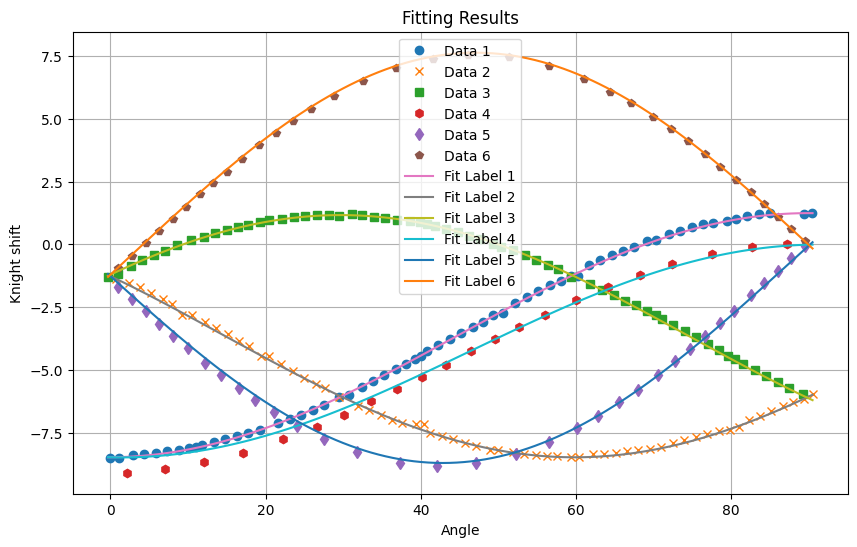

In [4]:
# データとラベルを結合
x_labels = np.vstack([x_data_combined, labels_combined]).T

# 目的関数の定義
def objective(x_labels, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    y_model = np.zeros(len(x_labels))
    for i, (x, label) in enumerate(x_labels):
        y_model[i] = model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2, label)
    return y_model

# フィッティング
initial_guess =  [-8.572, 1.146, 0, 8.830, 0, 0, 0, 0, 90, 0]   # 適切な初期値を設定
bounds = ([-10, -10, -10, -10, -10, -10, 0, 0, 0, 0], [10, 10, 10, 10, 10, 10, 90, 90, 90, 90])  # パラメータの範囲を設定
params, params_covariance = curve_fit(objective, x_labels, y_data_combined, p0=initial_guess, bounds=bounds)

print("Fitted parameters: Kxx =", params[0], "Kyy =", params[1], "Kzz =", params[2], "Kyz =", params[3], "Kzx =", params[4], "Kxy =", params[5], "t1 =", params[6], "p1 =", params[7], "t2 =", params[8], "p2 =", params[9])

# フィッティング結果のプロット
plt.figure(figsize=(10, 6))

# 各データセットのプロット
plt.plot(x_data_1, y_data_1, 'o', label='Data 1')
plt.plot(x_data_2, y_data_2, 'x', label='Data 2')
plt.plot(x_data_3, y_data_3, 's', label='Data 3')
plt.plot(x_data_4, y_data_4, 'h', label='Data 4')
plt.plot(x_data_5, y_data_5, 'd', label='Data 5')
plt.plot(x_data_6, y_data_6, 'p', label='Data 6')

# フィッティング結果のプロット
x_all = np.linspace(min(x_data_combined), max(x_data_combined), 100)
for label in [1, 2, 3, 4, 5, 6]:
    y_fit = np.array([model(x, *params, label) for x in x_all])
    plt.plot(x_all, y_fit, label=f'Fit Label {label}')

plt.xlabel('Angle')
plt.ylabel('Knight shift')
plt.title('Fitting Results')
plt.legend()
plt.grid(True)

plt.show()